In [1]:
import os
import re

from dmf_control_board_firmware.calibrate.impedance import TEST_LOADS
from dmf_control_board_firmware.chip_test.plot import plot_capacitance_summary
from ipywidgets import SelectMultiple
from path_helpers import path
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd

## Choose data files to merge data from

In [2]:
# Get current working directory.
pwd = path(os.getcwd())

start_name_i = len('channel-impedances-')
data_paths = [(f.name[start_name_i:], f)
              for f in
              sorted(pwd.parent.walkfiles('channel-impedances*.h5'),
                     key=lambda v: -v.mtime)]
selection = SelectMultiple(options=data_paths,
                           selected_labels=[data_paths[0][0]])
selection

## Merge impedance data frames from selected files

In [3]:
frames = []

# Load `channel_impedances` frame from selected files.
for hdf_path_i in selection.value:
    match = re.search(r'\[(?P<tag>.*)\]', hdf_path_i)
    if not match:
        continue
    df_channel_impedances_i = pd.read_hdf(str(hdf_path_i),
                                          '/channel_impedances')
    df_channel_impedances_i.insert(0, 'tag', match.group('tag'))
    frames.append(df_channel_impedances_i)
    
# Merge frames.
df_channel_impedances = pd.concat(frames)

# Load electrode/channel mapping and device geometry information
# (e.g., electrode shapes).
hdf_store = pd.HDFStore(str(hdf_path_i), 'r')
data = {k[1:]: hdf_store[k] for k in ['/shapes',
                                      '/device/electrodes_by_channel',
                                      '/device/channels_by_electrode']}
hdf_store.close()
data['channel_impedances'] = df_channel_impedances

--------------------------------------------------

## Compare to loads on test board

In [4]:
%matplotlib inline

In [5]:
TEST_LOADS_40 = TEST_LOADS
TEST_LOADS_120 = pd.Series(np.tile(TEST_LOADS_40[::2], 6),
                           index=range(3 * TEST_LOADS_40.shape[0]))

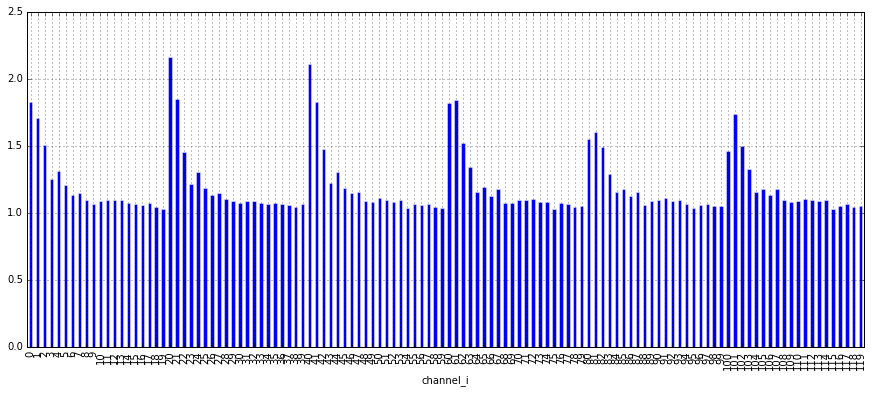

In [6]:
channel_capacitance = (df_channel_impedances.groupby('channel_i')
                       ['capacitance'].mean()) / TEST_LOADS_120
fig, axis_bar = plt.subplots(figsize=(15, 6))

with mpl.style.context(['ggplot']):
    axis = channel_capacitance.plot(kind='bar')